In [87]:
import jax
# ESTA ES LA FORMA CORRECTA
from jax import config
import jax
# Habilitar 64-bit float precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, random, jit, vmap 
from functools import partial
from jax.scipy.stats import norm
from jax.example_libraries import optimizers
from jax.example_libraries.stax import Dense, Relu, serial
import numpy as np
import matplotlib.pyplot as plt 
from IPython import display


# Gas de Coulomb clásico 

### Nos gustaría estudiar la propiedad termodinámica del gas clásico de Coulomb, cuyo hamiltoniano se lee


$$H=\sum_{i\lt j}^{} \frac{1}{\left| x_i-x_j \right|}+\sum_{i}^{} x^{2}_i $$

El segundo termino es una trampa de potencial armonico. Facilita nuestra explicación ( No necesitamos considerar condición de contorno periodica, ni la suma de Ewald para interacciones de largo alcance)

Lo que hay que hacer es minimizar la energia variacional libre con respecto a una densidad de probabilidad variacional $p(\boldsymbol{x})$


$$\mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left [\frac{1}{\beta}\ln p(\boldsymbol{x}) +  H(\boldsymbol{x}) \right] \ge -\frac{1}{\beta} \ln Z$$ 



donde $Z = \int d \boldsymbol{x} e^{-\beta H}$ y $beta$ el inverso de la temperatura. La igualdad se mantiene cuando $p(\boldsymbol{x}) = e^{-\beta H}/Z$ ,  es decir, logramos la solucion exacta. 

Primero lo primero, aqui tenemos la funcion de energia



In [413]:

n = 6
dim = 2

i, j = np.triu_indices(n, k=1)
q = jnp.array([1, 1, 1, -1, -1, -1], dtype=jnp.float64)  # debe tener longitud n

In [414]:
def energy_mat(
    X, q,
    k_trap=0.5, k_coul=1.0,
    k_core=0.5, sigma=0.05, p=4, a=1e-2 # parámetros para la parte de repulsión núcleo-núcleo que mejor funcionan k_core=0.5, sigma=0.05, p=4, a=1e-2
):
    # X: (n, dim)
    dX = X[:, None, :] - X[None, :, :]
    dist2 = jnp.sum(dX**2, axis=-1)
    r = jnp.sqrt(dist2[i, j] + a**2)

    qq = q[i] * q[j]
    V_coul = jnp.sum(k_coul * qq / r)
    V_core = jnp.sum(k_core * (sigma / r)**p)
    V_ext  = k_trap * jnp.sum(X**2)
    return V_ext + V_coul + V_core



In [415]:

# Wrapper para X con forma (n, dim)
def energy_wrapped(
    X, n, dim,
    k_trap=0.5, k_coul=1.0,
    k_core=0.5, sigma=0.05, p=4, a=1e-2
):
    return energy_mat(X, q, k_trap, k_coul, k_core, sigma, p, a)



In [416]:

# Wrapper para x plano (n*dim,) 
def energy_flat(
    x, n, dim,
    k_trap=0.5, k_coul=1.0,
    k_core=0.5, sigma=0.05, p=4, a=1e-2
):
    X = jnp.reshape(x, (n, dim))
    return energy_mat(X, q, k_trap, k_coul, k_core, sigma, p, a)

# Modelo generativo 

In [417]:
def layer (transform):
    def init_fun(rng, input_dim):
        cutoff = input_dim // 2
        perm = jnp.arange(input_dim)[::-1]
        params, trans_fun = transform(rng, cutoff, 2 * (input_dim - cutoff))

        def direct_fun(params, inputs):
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            st = trans_fun(params, lower)
            
            log_weight, bias = jnp.split(st, 2 , axis =-1)
            log_weight = 0.5 * jnp.tanh(log_weight)   # o jnp.clip(log_weight, -2.0, 2.0)
            bias = 0.5 * jnp.tanh(bias)               # o jnp.clip(bias, -2.0, 2.0)
            upper = upper * jnp.exp(log_weight) + bias

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs[:,perm], log_det_jacobian

        def inverse_fun(params, inputs):
            inputs = inputs[:, perm]
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            st = trans_fun(params, lower)
            log_weight, bias = jnp.split(st, 2 , axis =-1)
            log_weight = 0.5 * jnp.tanh(log_weight)   # o jnp.clip(log_weight, -2.0, 2.0)
            bias = 0.5 * jnp.tanh(bias)               # o jnp.clip(bias, -2.0, 2.0)
            upper = (upper - bias) * jnp.exp(-log_weight)

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = - log_weight.sum(-1)
            return outputs, log_det_jacobian

        return params, direct_fun, inverse_fun
    
    return init_fun

In [418]:
def RealNVP(transform, n: int):

    def init_fun(rng, input_dim):

        all_params, direct_funs, inverse_funs = [], [], []
        for _ in range(n):
            rng, layer_rng = random.split(rng)
            init_fun = layer(transform)
            param, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

            all_params.append(param)
            direct_funs.append(direct_fun)
            inverse_funs.append(inverse_fun)

        def feed_forward(params, apply_funs, inputs):
            log_det_jacobians = jnp.zeros(inputs.shape[:1])
            for apply_fun, param in zip(apply_funs, params):
                inputs, log_det_jacobian = apply_fun(param, inputs)
                log_det_jacobians += log_det_jacobian
            return inputs, log_det_jacobians

        def direct_fun(params, inputs):
            return feed_forward(params, direct_funs, inputs)

        def inverse_fun(params, inputs):
            return feed_forward(reversed(params), reversed(inverse_funs), inputs)

        return all_params, direct_fun, inverse_fun

    return init_fun

# Funcion de costo 


In [419]:
def make_reinforce_loss(flow_inverse, n, dim, beta):

    batch_energy = vmap(energy_flat, (0, None, None), 0)

    def loss(params, outputs):
        inputs, log_det_jacobian = flow_inverse(params, outputs)
        log_prob = norm.logpdf(inputs).sum(-1)
        entropy = log_prob + log_det_jacobian
        energy = batch_energy(outputs, n, dim)
        f = entropy/beta + energy
        f = lax.stop_gradient(f)

        f_mean = jnp.mean(f)
        f_std = jnp.std(f)/jnp.sqrt(f.shape[0])
            
        return jnp.mean((f - f_mean) * entropy), (f_mean, f_std)
    return loss

# Inicialización 


In [420]:
batchsize = 8500
n = 6
dim = 2
beta = 10.0
nlayers = 2
rng = random.PRNGKey(42)

def transform(rng, cutoff: int, other: int):
            net_init, net_apply = serial(Dense(16), Relu, Dense(16), Relu, Dense(other))
            in_shape = (-1, cutoff)
            out_shape, net_params = net_init(rng, in_shape)
            return net_params, net_apply

flow_init = RealNVP(transform, nlayers)
    
init_rng, rng = random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, n*dim)

In [421]:
loss = make_reinforce_loss(flow_inverse, n, dim, beta)
value_and_grad = jax.value_and_grad(loss, argnums=0, has_aux=True)

In [422]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(params)

# Entrenamiento 


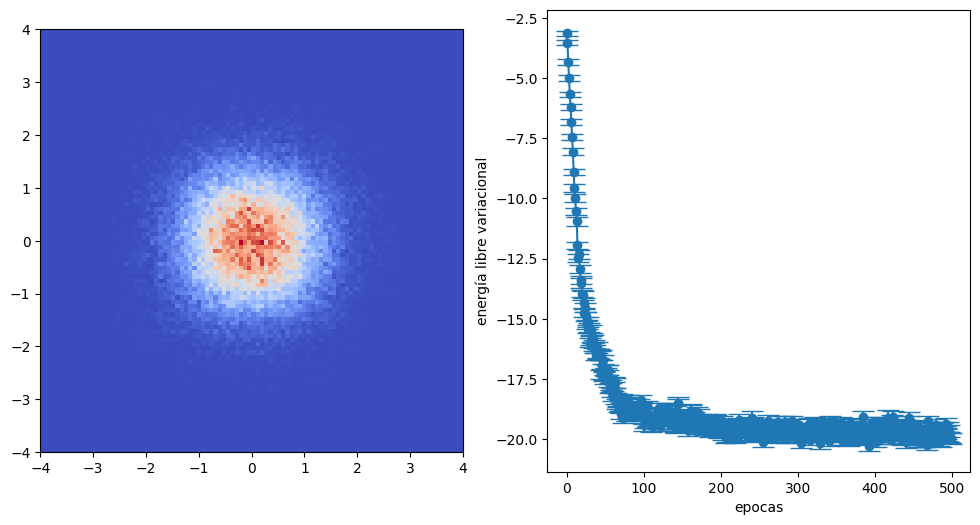

[Array(-19.96436947, dtype=float64), Array(0.2263942, dtype=float64)]


In [423]:
@jit
def step(rng, i, opt_state):
    params = get_params(opt_state)
    
    batch_inputs = jax.random.normal(rng, (batchsize, n*dim)) 
    outputs, _ = flow_forward(params, batch_inputs)

    value, grad = value_and_grad(params, outputs)

    opt_state = opt_update(i, grad, opt_state)
    return value, opt_state, outputs

loss_history = []
for i in range(500):
    step_rng, rng = jax.random.split(rng)
    value, opt_state, x = step(step_rng, i, opt_state)
    _, (f_mean, f_err) = value

    loss_history.append([f_mean, f_err])
    print(f_mean, f_err)

    x = jnp.reshape(x, (batchsize*n, dim)) 

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)
    plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="coolwarm")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.reshape(np.array(loss_history), (-1, 2))
    plt.errorbar(np.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    plt.xlabel('epocas')
    plt.ylabel('energía libre variacional')
    plt.pause(0.01)
print(loss_history[-1])






Veamos la energia del sistema despues de la optimizacion 

In [424]:
sample_realnvp = x.reshape(batchsize, n, dim)
energy_realnvp = vmap(energy_flat, (0, None, None), 0)(sample_realnvp, n, dim)
print(jnp.mean(energy_realnvp), jnp.std(energy_realnvp)/jnp.sqrt(batchsize))



2073.6294585151304 0.1361063654679568


Do you see structure emerges from training? 
Yes! It is called [Wigner molecule](https://en.wikipedia.org/wiki/Wigner_crystal). Physicists had already studied [the ground state of Wigner crystals for such small clusters](https://www.sciencedirect.com/science/article/abs/pii/S0749603683710268). the interesting result is that for the case of six electrons, there are five electrons arranged around a single electron at the center, which is actually what we get.

A few things to improve from this mininist implementation: 
* It seems the training breaks rotational invariance. But it shouldn't. How to incorporate that into the model design ? 

* How about the permutation invariance of the probability $p(\mathcal{P}\boldsymbol{x}) = p(\boldsymbol{x})$ ?

* Do you feel it is a bit ackward to integrate the equation twice (one for sampling, one for the likelihood). It is actually easier to implement "reparametrization" gradient estimator. Code it and see why we were not using it here. Again, read https://arxiv.org/abs/1906.10652 for more details 

# MCMC


In [389]:
@partial(jit, static_argnums=0)
def mcmc(logp_fn, x_init, key, mc_steps, mc_width):
    """
        Markov Chain Monte Carlo sampling algorithm.

    INPUT:
        logp_fn: callable that evaluate log-probability of a batch of configuration x.
            The signature is logp_fn(x), where x has shape (batch, n, dim).
        x_init: initial value of x, with shape (batch, n, dim).
        key: initial PRNG key.
        mc_steps: total number of Monte Carlo steps.
        mc_width: size of the Monte Carlo proposal.

    OUTPUT:
        x: resulting batch samples, with the same shape as `x_init`.
    """
    def step(i, state):
        x, logp, key, num_accepts = state
        key, key_proposal, key_accept = jax.random.split(key, 3)
        
        x_proposal = x + mc_width * jax.random.normal(key_proposal, x.shape)
        logp_proposal = logp_fn(x_proposal)

        ratio = jnp.exp((logp_proposal - logp))
        accept = jax.random.uniform(key_accept, ratio.shape) < ratio

        x_new = jnp.where(accept[:, None, None], x_proposal, x)
        logp_new = jnp.where(accept, logp_proposal, logp)
        num_accepts += accept.sum()
        return x_new, logp_new, key, num_accepts
    
    logp_init = logp_fn(x_init)

    x, logp, key, num_accepts = jax.lax.fori_loop(0, mc_steps, step, (x_init, logp_init, key, 0.))
    batch = x.shape[0]
    accept_rate = num_accepts / (mc_steps * batch)
    return x, accept_rate

In [390]:
@partial(jax.vmap, in_axes=(None, 0, None, None))
def logp(beta, x, n, dim):
    return -beta * energy_flat(x, n, dim)

In [391]:
mc_steps = 100 
mc_width = 0.05

init_rng, rng = random.split(rng)

x = random.normal(init_rng, (batchsize, n, dim))

for _ in range(20):
    mcmc_rng, rng = random.split(rng)
    x, acc = mcmc(lambda x: logp(beta, x, n, dim), x, mcmc_rng, mc_steps, mc_width)
    e = vmap(energy_flat, (0, None, None), 0)(x, n, dim)
    print (acc, jnp.mean(e), jnp.std(e)/jnp.sqrt(batchsize))

0.4210376470588235 2038.254072497372 0.2718883008123263
0.1505635294117647 2023.3286134598427 0.22283434524954956
0.04534117647058823 2018.1051713776606 0.18540949457910688
0.014363529411764706 2016.5318175407588 0.1784579991878267
0.008904705882352941 2015.8290876947694 0.18073049036070923
0.007909411764705882 2015.3093435390088 0.18469997465822585
0.007610588235294117 2014.794048969847 0.1886917163528463
0.007488235294117647 2014.2137801151382 0.1922100920988259
0.007385882352941176 2013.712934300343 0.1956388760999789
0.0074964705882352945 2013.1838155100443 0.19868661876369342
0.007355294117647059 2012.6780768924361 0.20186569998143067
0.006977647058823529 2012.2154969027717 0.20487513971910412
0.006923529411764706 2011.7729947417713 0.2072178957032273
0.006876470588235294 2011.3479805284765 0.209413819735006
0.006764705882352941 2010.9108130932034 0.21179688900594815
0.006711764705882353 2010.474337277139 0.21396908624631222
0.006711764705882353 2010.0143988978946 0.21567077852391

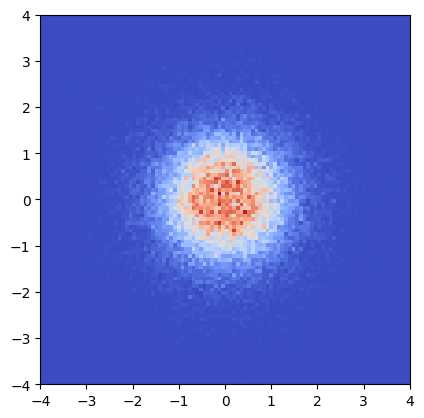

In [392]:
x = jnp.reshape(x, (batchsize*n, dim)) 
#density plot
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)

plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="coolwarm")

# Optimizando el estado de energia base


In [ ]:
def clip_by_global_norm(g, max_norm=10.0):
    leaves = jax.tree_util.tree_leaves(g)
    norm = jnp.sqrt(sum([jnp.sum(x**2) for x in leaves]))
    scale = jnp.minimum(1.0, max_norm / (norm + 1e-12))
    return jax.tree_util.tree_map(lambda x: x * scale, g)

# Inicial
key = jax.random.PRNGKey(0)
X_init = jax.random.normal(key, (n, dim), dtype=jnp.float64)

energy_and_grad = jax.value_and_grad(
    lambda X: energy_mat(
        X, q, 
        k_trap=1.0,
          # El parametro k_trap controla la fuerza del potencial de trampa, si es muy grande las partículas se quedan muy cerca del origen, si es muy pequeño las partículas se dispersan mucho
        k_coul=1.0,
          # El parametro k_coul controla la fuerza de la interacción coulombiana, si es muy grande las partículas se quedan muy cerca unas de otras, si es muy pequeño las partículas se quedan muy lejos unas de otras
        k_core=0.5,
          # El parametro k_core controla la fuerza de la repulsión núcleo-núcleo, si es muy grande las partículas se quedan muy lejos unas de otras, si es muy pequeño las partículas se quedan muy cerca unas de otras
        sigma=0.05,
          # El parametro sigma controla la distancia a la que se activa la repulsión núcleo-núcleo, si es muy grande las partículas se quedan muy lejos unas de otras, si es muy pequeño las partículas se quedan muy cerca unas de otras
        p=4,
          # El parametro p controla la forma de la repulsión núcleo-núcleo, si es muy grande las partículas se quedan muy lejos unas de otras, si es muy pequeño las partículas se quedan muy cerca unas de otras
        a=1e-2
          # El parametro a controla la suavización de la interacción coulombiana, si es muy grande las partículas se quedan muy lejos unas de otras, si es muy pequeño las partículas se quedan muy cerca unas de otras
    )
)

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)  # El paso de optimización controla la velocidad a la que se actualizan las posiciones de las partículas, 
#si es muy grande las partículas se mueven mucho en cada paso y pueden no converger, si es muy pequeño las partículas se mueven poco en cada paso y pueden tardar mucho en converger
opt_state = opt_init(X_init)

@jit
def energy_step(i, opt_state):
    X = get_params(opt_state)
    E, g = energy_and_grad(X)
    g = clip_by_global_norm(g, max_norm=10.0)
    opt_state = opt_update(i, g, opt_state)
    return E, opt_state, X

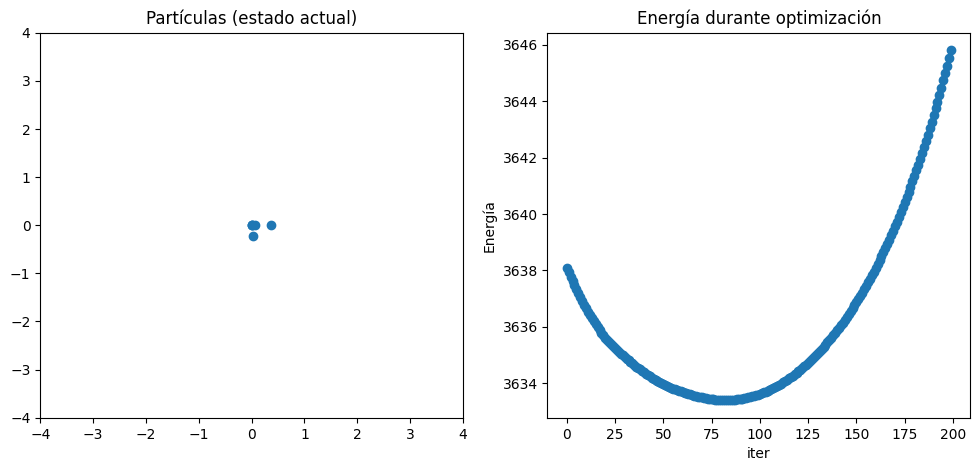

E final: 3645.8084994926626
X final:
 [[-3.46905147e-06 -2.36663456e-04]
 [ 3.69509979e-01  3.12260472e-06]
 [-2.59065169e-07 -1.43694090e-05]
 [ 5.70134861e-02 -6.17192544e-06]
 [-2.24819741e-06 -3.18663979e-03]
 [ 2.44888474e-02 -2.14552502e-01]]


In [408]:
energy_history = []

for t in range(200):
    E, opt_state, X = energy_step(t, opt_state)
    energy_history.append(float(E))

    X_np = np.array(X)
    if not np.isfinite(X_np).all() or not np.isfinite(energy_history[-1]):
        print("NaN/Inf detectado. Sube k_core/sigma o baja step_size.")
        break

    display.clear_output(wait=True)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X_np[:, 0], X_np[:, 1])
    plt.xlim([-4, 4]); plt.ylim([-4, 4])
    plt.title("Partículas (estado actual)")

    plt.subplot(1, 2, 2)
    plt.plot(energy_history, marker='o')
    plt.xlabel("iter"); plt.ylabel("Energía")
    plt.title("Energía durante optimización")

    plt.pause(0.01)

print("E final:", energy_history[-1])
print("X final:\n", np.array(get_params(opt_state)))

# Sumario 


### Pregunta final 